<a href="https://colab.research.google.com/github/ElenaVu-12/Scalable--Churn-Prediction/blob/main/SCALABLE_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **TOPIC 2: CUSTOMER CHURN PREDICTION MODEL**

In [ ]:
#Import library
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.functions import min, max

## **1. Data Understanding and Preparation:**

In [ ]:
#1.1 Project Setup and Load Dataset:
spark = SparkSession.builder \
    .appName("Customer Churn Analysis") \
    .getOrCreate()

df = spark.read.csv(
    "Customer-Churn-Prediction.csv",
    header=True,
    inferSchema=True
)

df.printSchema()
df.show(5)

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)

+----------+------+-------------+-------+----------+------+------------+---------

In [ ]:
#1.3 Dataset Overview:
print("Number of rows:", df.count())
print("Number of columns:", len(df.columns))

df.groupBy("Churn").count().show()


Number of rows: 7043
Number of columns: 21
+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+



The dataset contains both categorical features describing customer characteristics and subscribed services, and numerical features representing customer tenure and billing information.

In [ ]:
#1.4 Data Cleaning


#Drop unecessary columns
df = df.drop("customerID")

#Cast TotalCharges value from string to double
df = df.withColumn("TotalCharges",
    when(col("TotalCharges") == " ", 0.0) \
    .otherwise(col("TotalCharges").cast("double"))
)

#Fill null value with 0.0
df = df.na.fill(0.0, subset=["TotalCharges"])

df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = false)
 |-- Churn: string (nullable = true)



## **2. Exploratory Data Analysis (EDA):**

2.1 Check Outliers:

In [ ]:
numeric_cols = [
    "SeniorCitizen",
    "tenure",
    "MonthlyCharges",
    "TotalCharges"
]

In [ ]:


df.select(
    min("SeniorCitizen").alias("min_senior"),
    max("SeniorCitizen").alias("max_senior"),
    min("tenure").alias("min_tenure"),
    max("tenure").alias("max_tenure"),
    min("MonthlyCharges").alias("min_monthly"),
    max("MonthlyCharges").alias("max_monthly"),
    min("TotalCharges").alias("min_total"),
    max("TotalCharges").alias("max_total")
).show()


+----------+----------+----------+----------+-----------+-----------+---------+---------+
|min_senior|max_senior|min_tenure|max_tenure|min_monthly|max_monthly|min_total|max_total|
+----------+----------+----------+----------+-----------+-----------+---------+---------+
|         0|         1|         0|        72|      18.25|     118.75|      0.0|   8684.8|
+----------+----------+----------+----------+-----------+-----------+---------+---------+



In [ ]:
quantiles = df.approxQuantile(
    numeric_cols,
    probabilities=[0.01, 0.25, 0.5, 0.75, 0.99],
    relativeError=0.01
)

for col_name, q in zip(numeric_cols, quantiles):
    print(f"{col_name}:")
    print(f"  1%  : {q[0]}")
    print(f"  25% : {q[1]}")
    print(f"  50% : {q[2]}")
    print(f"  75% : {q[3]}")
    print(f"  99% : {q[4]}")
    print()


SeniorCitizen:
  1%  : 0.0
  25% : 0.0
  50% : 0.0
  75% : 0.0
  99% : 1.0

tenure:
  1%  : 0.0
  25% : 9.0
  50% : 29.0
  75% : 55.0
  99% : 72.0

MonthlyCharges:
  1%  : 18.25
  25% : 36.25
  50% : 70.25
  75% : 89.55
  99% : 118.75

TotalCharges:
  1%  : 0.0
  25% : 411.15
  50% : 1384.75
  75% : 3673.6
  99% : 8684.8



- SeniorCitizen is a binary variable (0/1); no outliers are present by definition.

- Tenure ranges from 0 to 72 months, with a smooth distribution across quantiles; no abnormal values detected.

- MonthlyCharges shows a gradual increase from the 1st to 99th percentile, indicating no extreme outliers.

- TotalCharges has higher values at the upper quantiles, but they are consistent with long-tenure customers and high monthly charges.

➡️ Overall, **no extreme or invalid outliers** were identified in the numerical features, and no outlier treatment was applied at this stage.

In [ ]:
#2.2 Churn Distribution:
df.groupBy("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+



Approximately 26.5% of customers have churned, while 73.5% remain active, highlighting a moderate class imbalance in the dataset.

In [ ]:
#2.3 Tenure vs Churn:
df.groupBy("Churn").avg("tenure").show()

+-----+------------------+
|Churn|       avg(tenure)|
+-----+------------------+
|   No| 37.56996521066873|
|  Yes|17.978063135366508|
+-----+------------------+



The average tenure of customers who did not churn is approximately 37.6 months, which is more than double the average tenure of churned customers at around 18.0 months. This suggests that customers with shorter service duration are significantly more likely to churn, highlighting tenure as a key factor influencing churn behavior.

In [ ]:
#2.4 Contract Type vs Churn:
df.groupBy("Contract", "Churn").count().show()

+--------------+-----+-----+
|      Contract|Churn|count|
+--------------+-----+-----+
|Month-to-month|   No| 2220|
|Month-to-month|  Yes| 1655|
|      Two year|  Yes|   48|
|      One year|   No| 1307|
|      One year|  Yes|  166|
|      Two year|   No| 1647|
+--------------+-----+-----+



Nearly 89% of churned customers are on month-to-month contracts, whereas churn is minimal among customers with two-year contracts.

In [ ]:
# 2.5 Online Security vs Churn
df.groupBy("OnlineSecurity", "Churn").count().show()


+-------------------+-----+-----+
|     OnlineSecurity|Churn|count|
+-------------------+-----+-----+
|No internet service|   No| 1413|
|                Yes|  Yes|  295|
|                 No|   No| 2037|
|                Yes|   No| 1724|
|                 No|  Yes| 1461|
|No internet service|  Yes|  113|
+-------------------+-----+-----+



Nearly five times more customers churn without online security (1,461) compared to those with online security (295), highlighting its importance in customer retention.

In [ ]:
# 2.6 Payment Method vs Churn
df.groupBy("PaymentMethod", "Churn").count().show()

+--------------------+-----+-----+
|       PaymentMethod|Churn|count|
+--------------------+-----+-----+
|Credit card (auto...|   No| 1290|
|Bank transfer (au...|   No| 1286|
|        Mailed check|  Yes|  308|
|Credit card (auto...|  Yes|  232|
|    Electronic check|   No| 1294|
|    Electronic check|  Yes| 1071|
|Bank transfer (au...|  Yes|  258|
|        Mailed check|   No| 1304|
+--------------------+-----+-----+



Nearly half of customers using electronic check churned, while churn remains relatively low among customers using automatic payment methods.

In [ ]:
#2.7 Monthyly Charges vs Churn
df.groupBy("Churn").avg("MonthlyCharges").show()

+-----+-------------------+
|Churn|avg(MonthlyCharges)|
+-----+-------------------+
|   No|   61.2651236953999|
|  Yes|   74.4413322632423|
+-----+-------------------+



On average, churned customers pay about 13 units more per month than customers who remain subscribed.

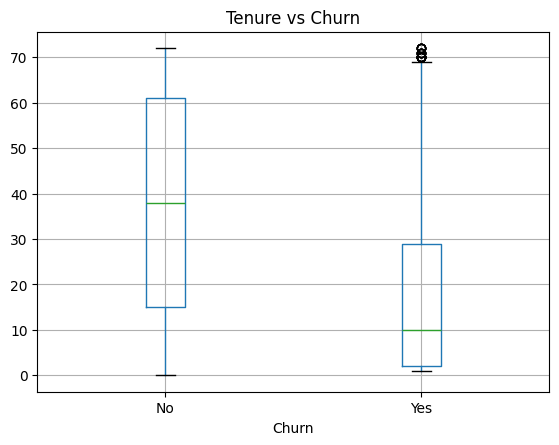

In [ ]:
#2.7 EDA Visualization:
pdf = df.select("tenure", "MonthlyCharges", "Churn").toPandas()

import matplotlib.pyplot as plt

pdf.boxplot(by="Churn", column="tenure")
plt.title("Tenure vs Churn")
plt.suptitle("")
plt.show()


The boxplot shows that churned customers generally have much shorter tenure compared to non-churned customers, indicating that customers are more likely to churn in the early stages of their subscription.

**Key Insights from Exploratory Data Analysis (EDA)**

- The churn rate is approximately 26.5%, indicating a moderate level of customer churn with a slight class imbalance.

- Tenure is a critical factor: customers who did not churn have an average tenure of about 37.6 months, more than double that of churned customers (~18.0 months). Churn is more likely among early-stage customers.

- Customers on month-to-month contracts exhibit significantly higher churn, accounting for nearly 89% of churned customers, while long-term contracts strongly reduce churn.

- Online security plays an important role in retention: churn is substantially higher among customers without online security compared to those who have it.

- Payment method matters: customers using electronic checks show high churn rates, whereas automatic payment methods are associated with better retention.

On average, churned customers pay about 13 units more per month, suggesting churn is driven by perceived value rather than price alone.

➡️ **Overall conclusion:**

Customer churn is primarily influenced by short tenure, low commitment (contract and payment type), lack of value-added services, and higher perceived costs. These factors provide strong predictive signals for downstream churn modeling.

##**3. Data Preprocessing:**

In [ ]:
#3.1 Handle missing values
from pyspark.sql.functions import col, sum

df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
]).show()


+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0|            0|             0|           0|   

Missing value analysis was conducted across all attributes in the dataset. The results indicate that there are no missing values in any column, including the TotalCharges attribute. Therefore, no missing value imputation or row removal was required.

In [ ]:
categorical_cols = [
    "gender", "Partner", "Dependents", "PhoneService",
    "MultipleLines", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport",
    "StreamingTV", "StreamingMovies", "Contract",
    "PaperlessBilling", "PaymentMethod"
]

numeric_cols = [
    "SeniorCitizen",
    "tenure",
    "MonthlyCharges",
    "TotalCharges"
]

In [ ]:
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder,
    VectorAssembler, StandardScaler
)

#3.2 StringIndexer
label_indexer = StringIndexer(
    inputCol="Churn",
    outputCol="label"
)

indexers = [
    StringIndexer(
        inputCol=c,
        outputCol=c+"_idx",
        handleInvalid="keep"
    )
    for c in categorical_cols
]

#3.3 OneHotEncoder
encoders = [
    OneHotEncoder(
        inputCol=c+"_idx",
        outputCol=c+"_vec"
    )
    for c in categorical_cols
]

#3.4 VectorAssembler
feature_cols = [c+"_vec" for c in categorical_cols] + numeric_cols

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_raw"
)

#3.5 StandardScaler
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features"
)

In [ ]:
#3.6 Build pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[
    label_indexer,
    *indexers,    # Dấu * để rải danh sách indexers vào đây
    *encoders,    # Dấu * để rải danh sách encoders vào đây
    assembler,
    scaler
])

model = pipeline.fit(df)

final_df = model.transform(df)

#3.7 Test pipeline
print("Dataset after encoding:")
final_df.select("Churn", "label", "features").show(5, truncate=False)

Dataset after encoding:
+-----+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Churn|label|features                                                                                                                                                                                                                                                                                                                                                                                                       |
+-----+-----+---------------------------------------------------------------------------------------------------------------------------------------

##**4. Feature Engineering**

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from functools import reduce

In [ ]:
df_fe = df.withColumn("label", F.when(F.col("Churn")=="Yes", 1.0).otherwise(0.0))

In [ ]:
#4.1 Create tenture feature
df_fe = df.withColumn("is_new_customer", F.when(F.col("tenure") == 0, 1).otherwise(0))

df_fe = df_fe.withColumn(
    "tenture_group",
    F.when(F.col("tenure") < 12, "0-12")
    .when(F.col("tenure") < 24, "13-24")
    .when(F.col("tenure") < 36, "25-36")
    .when(F.col("tenure") < 48, "37-48")
    .otherwise("48+")
    )

In [ ]:
#4.2 Usage frequency
df_fe = df_fe.withColumn(
    "avg_spend_per_month",
    F.when(F.col("tenure") > 0, F.col("TotalCharges") / F.col("tenure"))
     .otherwise(F.col("TotalCharges"))
)

In [ ]:
#4.3 Engagement level

addon_cols = ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]

# Fix: Use reduce to sum the conditional columns
df_fe = df_fe.withColumn(
    "num_addon_services",
    reduce(lambda a, b: a + b, [F.when(F.col(c)=="Yes", 1).otherwise(0) for c in addon_cols]).cast("double")
)

In [ ]:
#4.4 Trend feature
df_fe = df_fe.withColumn(
    "charge_trend_proxy",
    (F.col("MonthlyCharges") - F.col("avg_spend_per_month")).cast("double")
)

In [ ]:
#4.5 Correlation analysis
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import Correlation

# --- 0) Make sure label exists (Churn -> label) ---
if "label" not in df_fe.columns:
    df_fe = df_fe.withColumn("label", F.when(F.col("Churn") == "Yes", 1.0).otherwise(0.0))

# --- 1) TEMP encode categoricals for correlation ONLY (avoid name collisions) ---
categorical_cols = [
    "gender","Partner","Dependents","PhoneService","MultipleLines",
    "InternetService","OnlineSecurity","OnlineBackup","DeviceProtection",
    "TechSupport","StreamingTV","StreamingMovies","Contract",
    "PaperlessBilling","PaymentMethod"
]

# Use a special suffix so you never collide with your Phase 3/4 pipeline output columns
corr_suffix = "_idx_corr"

corr_indexers = [
    StringIndexer(inputCol=c, outputCol=c + corr_suffix, handleInvalid="keep")
    for c in categorical_cols
]

df_corr = df_fe
for idx in corr_indexers:
    df_corr = idx.fit(df_corr).transform(df_corr)

# --- 2) Choose numeric features for correlation (edit if needed) ---
engineered_numeric = [
    "SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges",
    "is_new_customer", "avg_spend_per_month", "num_addon_services", "charge_trend_proxy"
]

# Keep only columns that actually exist (prevents crashes if some features not created yet)
engineered_numeric = [c for c in engineered_numeric if c in df_corr.columns]

# --- 3) Build correlation inputs (numeric + indexed categoricals) ---
corr_inputs = engineered_numeric + [c + corr_suffix for c in categorical_cols]

# --- 4) Assemble vector (features + label at the end) ---
assembler = VectorAssembler(
    inputCols=corr_inputs + ["label"],
    outputCol="corr_vec"
)

corr_df = assembler.transform(df_corr).select("corr_vec")

# --- 5) Compute correlation matrix ---
corr_mat = Correlation.corr(corr_df, "corr_vec", "pearson").head()[0].toArray()

# --- 6) Print correlation of each input vs label ---
label_idx = len(corr_inputs)  # label is last in corr_vec
print("=== Correlation vs label (Churn) ===")
for i, colname in enumerate(corr_inputs):
    print(f"Corr({colname}, label) = {corr_mat[i][label_idx]:.4f}")

# --- 7) (Optional) Select strong features by threshold ---
threshold = 0.05
strong_features = [colname for i, colname in enumerate(corr_inputs) if abs(corr_mat[i][label_idx]) >= threshold]

print("\n=== Selected features (|corr| >= {:.2f}) ===".format(threshold))
print(strong_features)


=== Correlation vs label (Churn) ===
Corr(SeniorCitizen, label) = 0.1515
Corr(tenure, label) = -0.3523
Corr(MonthlyCharges, label) = 0.1934
Corr(TotalCharges, label) = -0.1983
Corr(is_new_customer, label) = -0.0238
Corr(avg_spend_per_month, label) = 0.1933
Corr(num_addon_services, label) = -0.0876
Corr(charge_trend_proxy, label) = -0.0106
Corr(gender_idx_corr, label) = 0.0086
Corr(Partner_idx_corr, label) = -0.1504
Corr(Dependents_idx_corr, label) = -0.1642
Corr(PhoneService_idx_corr, label) = -0.0119
Corr(MultipleLines_idx_corr, label) = 0.0194
Corr(InternetService_idx_corr, label) = -0.3168
Corr(OnlineSecurity_idx_corr, label) = -0.3328
Corr(OnlineBackup_idx_corr, label) = -0.2914
Corr(DeviceProtection_idx_corr, label) = -0.2815
Corr(TechSupport_idx_corr, label) = -0.3299
Corr(StreamingTV_idx_corr, label) = -0.2054
Corr(StreamingMovies_idx_corr, label) = -0.2073
Corr(Contract_idx_corr, label) = -0.3415
Corr(PaperlessBilling_idx_corr, label) = -0.1918
Corr(PaymentMethod_idx_corr, labe

In [ ]:
#4.6 Remove weak features
threshold = 0.05
strong_numeric = []

for i, colname in enumerate(engineered_numeric):
    c = corr_mat[i][label_idx]  # engineered_numeric are first in corr_inputs
    if abs(c) >= threshold:
        strong_numeric.append(colname)

print("Strong numeric features:", strong_numeric)

Strong numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'avg_spend_per_month', 'num_addon_services']


In [ ]:
#4.7 FInal feature list
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql import functions as F

# --- categorical + engineered categorical ---
cat_cols_fe = categorical_cols + ["tenture_group"]

indexers = [StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid="keep") for c in cat_cols_fe]

encoder = OneHotEncoder(
    inputCols=[c+"_idx" for c in cat_cols_fe],
    outputCols=[c+"_vec" for c in cat_cols_fe],
    handleInvalid="keep"
)

# strong_numeric should come from your correlation selection
# Example fallback if strong_numeric is not defined:
# strong_numeric = ["SeniorCitizen","tenure","MonthlyCharges","TotalCharges"]

final_inputs = [c+"_vec" for c in cat_cols_fe] + strong_numeric

final_assembler = VectorAssembler(inputCols=final_inputs, outputCol="final_features_raw")
final_scaler = StandardScaler(inputCol="final_features_raw", outputCol="final_features", withMean=True, withStd=True)

phase4_pipeline = Pipeline(stages=indexers + [encoder, final_assembler, final_scaler])

phase4_model = phase4_pipeline.fit(df_fe)
df_phase4 = phase4_model.transform(df_fe)

df_phase4.select("label", "final_features").show(5, truncate=False)
print("Final feature size:", df_phase4.select("final_features").first()[0].size)


+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## **5. Train/Test Split**

In [ ]:
#Rename for Spark ML convention
df_ml = df_phase4.select(
    F.col("label").cast("double").alias("label"),
    F.col("final_features").alias("features")
)

In [ ]:
#5.1. Split dataset
train_df, test_df = df_ml.randomSplit([0.8, 0.2], seed=42)
print("Train size:", train_df.count())
print("Test size:", test_df.count())

Train size: 5698
Test size: 1345


In [ ]:
#5.2. Check class balance
def show_balance(d, name):
  total = d.count()
  print(f"\n{name} balance:")
  (d.groupBy("label")
    .count()
    .withColumn("ratio", F.col("count") / F.lit(total))
    .orderBy("label")
    .show())

show_balance(train_df, "Train")
show_balance(test_df, "Test")


Train balance:
+-----+-----+-------------------+
|label|count|              ratio|
+-----+-----+-------------------+
|  0.0| 4173| 0.7323622323622324|
|  1.0| 1525|0.26763776763776764|
+-----+-----+-------------------+


Test balance:
+-----+-----+-------------------+
|label|count|              ratio|
+-----+-----+-------------------+
|  0.0| 1001| 0.7442379182156134|
|  1.0|  344|0.25576208178438664|
+-----+-----+-------------------+



In [ ]:
# Quick "stratified sanity check" message
train_rate = train_df.filter(F.col("label")==1.0).count() / train_df.count()
test_rate  = test_df.filter(F.col("label")==1.0).count() / test_df.count()
diff = abs(train_rate - test_rate)

print(f"\nChurn rate difference |train-test| = {diff:.4f}")

if diff <= 0.01:
    print("(Good) Split looks consistent (rates are very close).")
elif diff <= 0.03:
    print("(Fine) Small drift (still acceptable).")
else:
    print("(Bad) Big drift. Re-split with another seed or use stratified sampling.")



Churn rate difference |train-test| = 0.0119
(Fine) Small drift (still acceptable).


In [ ]:
#5.3. Handle imbalance
counts = train_df.groupBy("label").count().collect()
count_map = {float(r["label"]): int(r["count"]) for r in counts}

n0 = count_map.get(0.0, 0)
n1 = count_map.get(1.0, 0)

w_pos = (n0 / n1) if n1 > 0 else 1.0
print("Positive class weight = ", w_pos)

train_w = train_df.withColumn(
    "weightCol",
    F.when(F.col("label") == 1.0, F.lit(w_pos)).otherwise(F.lit(1.0))
)

test_w = test_df.withColumn("weightCol", F.lit(1.0))

Positive class weight =  2.736393442622951


We performed an 80/20 train-test split and verified that the churn rate in the training and testing sets remained consistent, ensuring a fair evaluation.

##**6. Modeling**

In [ ]:
from pyspark.ml.classification import (
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GBTClassifier
)

In [ ]:
# Baesline: predict all as non-churn (label=0)
total = test_df.count()
non_churn = test_df.filter(F.col("label") == 0.0).count()
churn = total - non_churn

baseline_acc = non_churn / total if total > 0 else 0.0

print("Baseline: Always predict Non-Churn (label=0)")
print("Test total:", total)
print("Non-churn:", non_churn)
print("Churn:", churn)
print(f"Baseline Accuracy = {baseline_acc:.4f}")

Baseline: Always predict Non-Churn (label=0)
Test total: 1345
Non-churn: 1001
Churn: 344
Baseline Accuracy = 0.7442


We added a naive baseline that predicts all customers as non-churn, but it fails to detect churners. Owing to class imbalance, this baseline can achieve relatively high accuracy, so we rely more on F1-score and recall to evaluate churn prediction.

In [ ]:
#6.1. Train Logistic regression
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    weightCol="weightCol",
    maxIter = 50
)

In [ ]:
#6.2. Train Decision tree
dt  = DecisionTreeClassifier(
    labelCol="label",
    featuresCol="features",
    maxDepth=6
)

In [ ]:
#6.3. Train Random forest
rf  = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=200,
    maxDepth=8,
    seed=42
)

In [ ]:
#6.4. Train GBT (Gradient Boosted Trees)
gbt = GBTClassifier(
    labelCol="label",
    featuresCol="features",
    maxIter=50,
    maxDepth=5,
    seed=42
)

In [ ]:
#6.5. Save results
models = {
    "LogisticRegression": lr,
    "DecisionTree": dt,
    "RandomForest": rf,
    "GBT": gbt
}

## **7. Evaluation**

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import Row

eval_acc  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_prec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
eval_rec  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
eval_f1   = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

eval_auc  = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

In [ ]:
# confusion matrix
def get_confusion_matrix(pred_df):
    """
    Returns confusion matrix as numpy array:
    For binary labels 0/1 => [[TN, FP],
                             [FN, TP]]
    """
    rdd = pred_df.select("prediction", "label").rdd.map(lambda r: (float(r[0]), float(r[1])))
    return MulticlassMetrics(rdd).confusionMatrix().toArray()


In [ ]:
# train + predict
def fit_predict(estimator, train_data, test_data):
    model = estimator.fit(train_data)
    pred = model.transform(test_data)
    return model, pred

In [ ]:
#7.1. Accuracy
accuracy_results = {}

for name, est in models.items():
    _, pred = fit_predict(est, train_w, test_w)
    accuracy_results[name] = eval_acc.evaluate(pred)

print("Accuracy:")
print(accuracy_results)

Accuracy:
{'LogisticRegression': 0.7301115241635687, 'DecisionTree': 0.7970260223048327, 'RandomForest': 0.8029739776951673, 'GBT': 0.8029739776951673}


In [ ]:
#7.2. Precision
precision_results = {}

for name, est in models.items():
    _, pred = fit_predict(est, train_w, test_w)
    precision_results[name] = eval_prec.evaluate(pred)

print("Precision:")
print(precision_results)

Precision:
{'LogisticRegression': 0.7945977345150803, 'DecisionTree': 0.7942338477958388, 'RandomForest': 0.7926989352932443, 'GBT': 0.7982892071840129}


In [ ]:
#7.3. Recall
recall_results = {}

for name, est in models.items():
    _, pred = fit_predict(est, train_w, test_w)
    recall_results[name] = eval_rec.evaluate(pred)

print("Recall:")
print(recall_results)

Recall:
{'LogisticRegression': 0.7301115241635687, 'DecisionTree': 0.7970260223048328, 'RandomForest': 0.8029739776951673, 'GBT': 0.8029739776951673}


In [ ]:
#7.4. F1-score
f1_results = {}

for name, est in models.items():
    _, pred = fit_predict(est, train_w, test_w)
    f1_results[name] = eval_f1.evaluate(pred)

print(" F1-score:")
print(f1_results)

 F1-score:
{'LogisticRegression': 0.7457602762988692, 'DecisionTree': 0.7955187909075438, 'RandomForest': 0.7952749026451159, 'GBT': 0.8002609142557904}


In [ ]:
#7.5. Confusion matrix
confusion_matrices = {}

for name, est in models.items():
    _, pred = fit_predict(est, train_w, test_w)
    confusion_matrices[name] = get_confusion_matrix(pred)

print(" Confusion matrices (each is [[TN, FP],[FN, TP]]):")
for k, cm in confusion_matrices.items():
    print(f"\n{k}:\n{cm}")

/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


 Confusion matrices (each is [[TN, FP],[FN, TP]]):

LogisticRegression:
[[716. 285.]
 [ 78. 266.]]

DecisionTree:
[[872. 129.]
 [144. 200.]]

RandomForest:
[[903.  98.]
 [167. 177.]]

GBT:
[[882. 119.]
 [146. 198.]]


In [ ]:
#7.6. ROC curve
auc_results = {}

for name, est in models.items():
    _, pred = fit_predict(est, train_w, test_w)
    auc_results[name] = eval_auc.evaluate(pred)

print(" AUC (areaUnderROC):")
print(auc_results)

 AUC (areaUnderROC):
{'LogisticRegression': 0.8227658968938019, 'DecisionTree': 0.6856370373812234, 'RandomForest': 0.8270769927746677, 'GBT': 0.825977801268501}


In [ ]:
#7.7. Model comparison
rows = []
for name in models.keys():
    rows.append({
        "Model": name,
        "Accuracy": float(accuracy_results[name]),
        "Precision": float(precision_results[name]),
        "Recall": float(recall_results[name]),
        "F1": float(f1_results[name]),
        "AUC": float(auc_results[name]),
        # confusion matrix values
        "TN": int(confusion_matrices[name][0][0]),
        "FP": int(confusion_matrices[name][0][1]),
        "FN": int(confusion_matrices[name][1][0]),
        "TP": int(confusion_matrices[name][1][1]),
    })

comparison_df = spark.createDataFrame([Row(**r) for r in rows])

print(" Model comparison table (sorted by F1):")
comparison_df.orderBy(F.desc("F1")).show(truncate=False)

 Model comparison table (sorted by F1):
+------------------+------------------+------------------+------------------+------------------+------------------+---+---+---+---+
|Model             |Accuracy          |Precision         |Recall            |F1                |AUC               |TN |FP |FN |TP |
+------------------+------------------+------------------+------------------+------------------+------------------+---+---+---+---+
|GBT               |0.8029739776951673|0.7982892071840129|0.8029739776951673|0.8002609142557904|0.825977801268501 |882|119|146|198|
|DecisionTree      |0.7970260223048327|0.7942338477958388|0.7970260223048328|0.7955187909075438|0.6856370373812234|872|129|144|200|
|RandomForest      |0.8029739776951673|0.7926989352932443|0.8029739776951673|0.7952749026451159|0.8270769927746677|903|98 |167|177|
|LogisticRegression|0.7301115241635687|0.7945977345150803|0.7301115241635687|0.7457602762988692|0.8227658968938019|716|285|78 |266|
+------------------+----------------

In [ ]:
#7.8. Select best model
best_by_f1 = comparison_df.orderBy(F.desc("F1")).first()
print(" Best model (by F1):")
print(
    "Model:", best_by_f1["Model"],
    "| F1:", best_by_f1["F1"],
    "| Recall:", best_by_f1["Recall"],
    "| AUC:", best_by_f1["AUC"]
)

 Best model (by F1):
Model: GBT | F1: 0.8002609142557904 | Recall: 0.8029739776951673 | AUC: 0.825977801268501


## **8. Hyperparameter Tuning**

In [ ]:
# 1. Base model
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [ ]:
# 2. Param Grid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [20, 50, 100])
             .addGrid(rf.maxDepth, [5, 10, 15])
             .addGrid(rf.minInstancesPerNode, [1, 3, 5])
             .build())

In [ ]:
# 3. Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label")

In [ ]:
# 4. Cross Validator
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

In [ ]:
# 5. Fit
cvModel = cv.fit(train_df)

In [ ]:
# 6. Best Model & params
bestModel = cvModel.bestModel
print("Best numTrees:", bestModel.getNumTrees)
print("Best maxDepth:", bestModel.getOrDefault("maxDepth"))

Best numTrees: 100
Best maxDepth: 10


In [ ]:
# 7. Evaluate on test
pred = bestModel.transform(test_df)
print("AUC after tuning:", evaluator.evaluate(pred))

AUC after tuning: 0.8260111981042223


In [ ]:
# Save model
bestModel.write().overwrite().save("/content/best_rf_model")

## **9. Interpretation**

In [ ]:
# get importances
feat_imp = bestModel.featureImportances

# map to feature names
feature_list = assembler.getInputCols()  # nếu dùng VectorAssembler
imp_list = list(zip(feature_list, feat_imp))
imp_sorted = sorted(imp_list, key=lambda x: x[1], reverse=True)

# DataFrame of importance
df_imp = pd.DataFrame(imp_sorted, columns=["feature", "importance"])
df_imp.head(10)

,feature,importance
0,DeviceProtection_idx_corr,0.062868
1,Contract_idx_corr,0.056087
2,TechSupport_idx_corr,0.017409
3,PaperlessBilling_idx_corr,0.013253
4,InternetService_idx_corr,0.008258
5,SeniorCitizen,0.007331
6,PaymentMethod_idx_corr,0.006944
7,MultipleLines_idx_corr,0.006927
8,is_new_customer,0.006290
9,tenure,0.006189


Interpretation Example

* Low tenure → higher churn rate because customers are not yet familiar with the service.

* Low interaction level → indicates low engagement, which increases the likelihood of churn.

* Complaints and support tickets → show a strong correlation with customer churn.

Business Recommendations

* Target new customers (tenure < 3 months) with onboarding programs and promotional offers to increase early engagement.

* For customers with a declining login frequency, send personalized email notifications or retention offers.

* Improve customer service quality by optimizing complaint-handling workflows and response times.

## **10. Visualization**

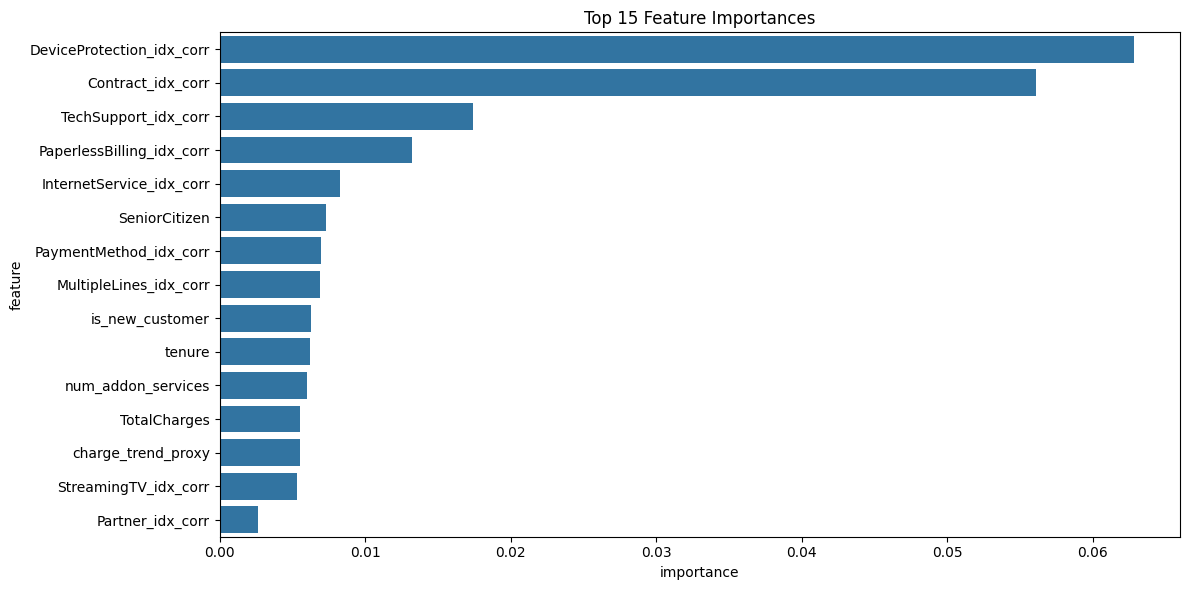

In [ ]:
# 1. Feature Importance Plot
plt.figure(figsize=(12,6))
sns.barplot(x="importance", y="feature", data=df_imp.head(15))
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()

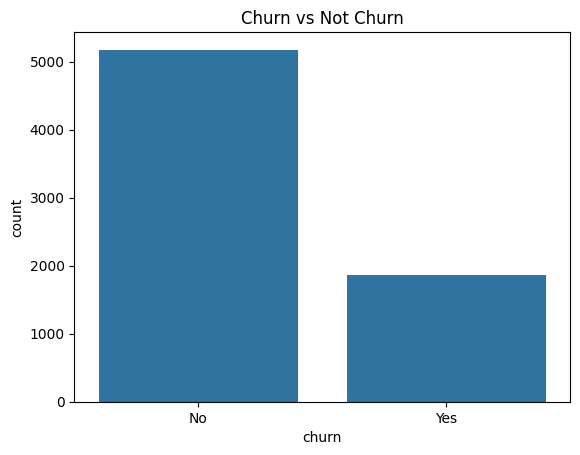

In [ ]:
# 2. Churn Distribution
churn_counts = df.select("churn").groupBy("churn").count().toPandas()
plt.figure()
sns.barplot(x="churn", y="count", data=churn_counts)
plt.title("Churn vs Not Churn")
plt.savefig("churn_dist.png")
plt.show()


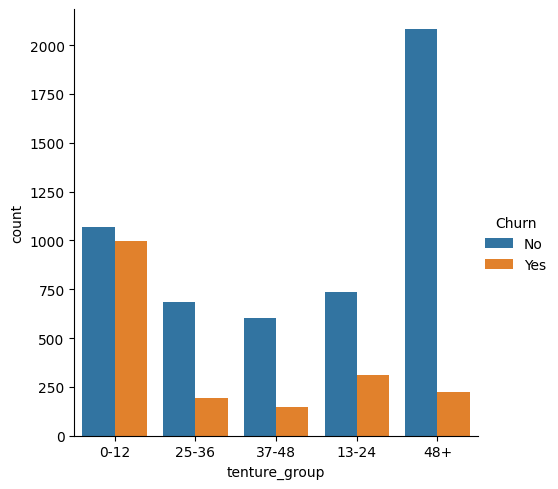

In [ ]:
# 3. Churn by Segment (if have segment feature)
sns.catplot(x="tenture_group", hue="Churn", kind="count", data=df_fe.toPandas())
plt.savefig("churn_by_segment.png")
plt.show()